In [1]:
import matplotlib.pyplot as plt
import numpy as np
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import PyQt5
import naive_conv as conv
import seaborn as sb

In [2]:
# prepare some coordinates
x, y, z = np.indices((12, 12, 12))

# draw cuboids in the top left and bottom right corners, and a link between them
input_tensor = (x >= 4) & (x < 9) & (y >= 4) & (y < 7) & (z >= 4) & (z < 8)
filter_tensor = (x >= 5) & (x < 8) & (y >= 4) & (y < 7) & (z >= 5) & (z < 8)
# filter_tensor = (x >= 4) & (y >= 9) & (z >= 9)

# combine the objects into a single boolean array
voxels = input_tensor | filter_tensor

colors = np.empty(voxels.shape + (4,), dtype=np.float32)


In [3]:
# set the colors of each object
colors = np.empty(voxels.shape + (4,), dtype=np.float32)
# colors[link] = (0.9, 0.0, 0.0)
# # colors[cube1, :] = 'blue'
# # colors[cube2, :] = 'green'
# colors[link]
colors[input_tensor, :] = ((0., 1., 0., 0.2))
colors[filter_tensor, :] = ((1., 1., 0.5, 0.5))

# colors = np.empty(voxels.shape, dtype=object)
# colors[cube1] = 'blue'
# colors[cube2] = 'green'

# voxels.shape == colors.shape

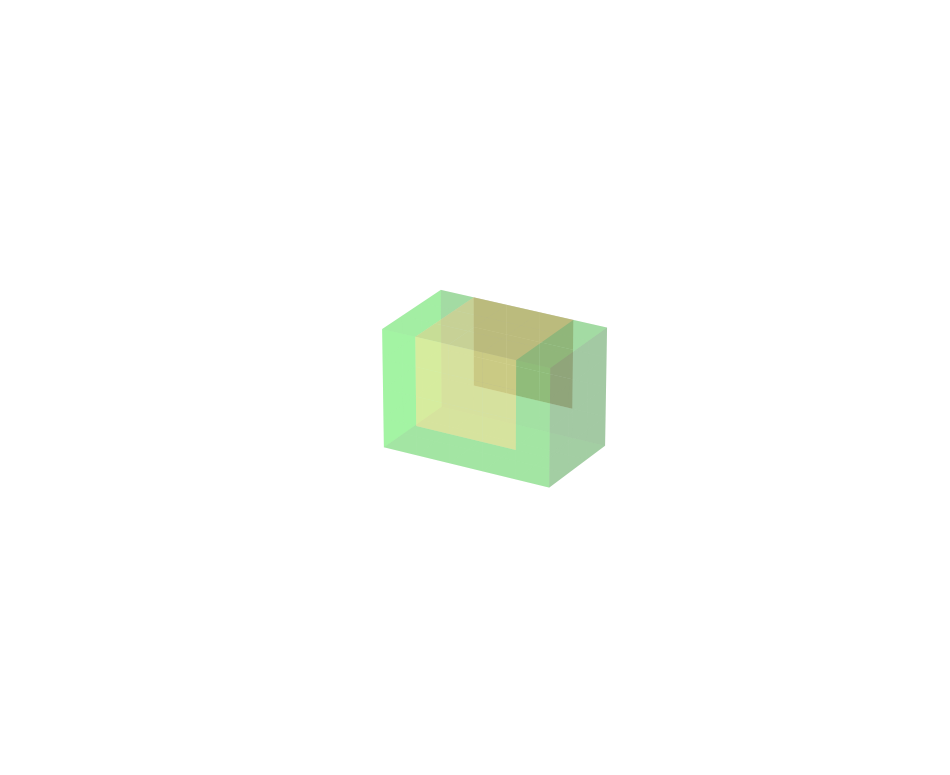

In [4]:
# and plot everything
fig = plt.figure(figsize=(12, 10), dpi=100)
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors)  # , edgecolor='k')
plt.axis('off')

plt.show()

In [38]:
class Cube:
    """
    Wrapper around Poly3DCollection used for plotting in Matplotlib,
    as well as containing the actual points.
    """
    
    def __init__(self, points):
        self._faces = [
            (points[0], points[1], points[2], points[3]),  # bottom
            (points[0], points[4], points[7], points[3]),  # front face
            (points[0], points[1], points[5], points[4]),  # left face
            (points[3], points[7], points[6], points[2]),  # right face
            (points[1], points[5], points[6], points[2]),  # back face
            (points[4], points[5], points[6], points[7]),  # top
        ]

        self._points = np.array([p for p in points]).reshape((len(points), 3))
        self._polycollection = Poly3DCollection(self._faces)

    def get_polycollection(self):
        return self._polycollection

    def get_points(self):
        return self._points

    def get_faces(self):
        return self._faces


def construct_cube(base, length_vec, width_vec, height_vec):
    """
    Represent cube with 8 points, transform points into faces,
    and return a collection of these faces representing the cube.
    """
    point0 = base
    point1 = base + length_vec
    point2 = base + length_vec + width_vec
    point3 = base + width_vec
    point4 = base + height_vec
    point5 = base + length_vec + height_vec
    point6 = base + length_vec + width_vec + height_vec
    point7 = base + width_vec + height_vec

    return Cube([point0, point1, point2, point3,
                 point4, point5, point6, point7])


def format_cube(cube, facecolours=None, linewidths=None, edgecolours=None, alpha=None):
    """
    Make the cube pretty and the tings.
    """
    polycollection = cube.get_polycollection()

    polycollection.set_facecolor(facecolours)
    polycollection.set_linewidths(linewidths)
    polycollection.set_edgecolor(edgecolours)
    polycollection.set_alpha(alpha)
    
    return cube

In [41]:
class Space:
    """
    Representation of a 3D cartesian coordinate space.
    This space contains geometric objects for plotting.
    """
    
    def __init__(self, ax, dims):
        self._ax = ax
        self._dims = dims
    
    def add_cube(self, cube):
        """
        Take in an axes-object as a 3D space, and add the cube to it. Make sure the space is
        large enough to encompass all objects in it. This is achieved by ensuring the space
        is centred around the geometric mean of the objects within it. Return the space.
        """
        bounding_box = get_bounding_box(cube.get_points())

        if self._dims == [None, None, None]:
            dim = [bounding_box[0], bounding_box[1], bounding_box[2]]
        else:
            dim = [[min(self._dims[i][0], bounding_box[i][0]), 
                    max(self._dims[i][1], bounding_box[i][1])] for i in range(len(bounding_box))]

        self._dims = dim

        self._ax.add_collection3d(cube.get_polycollection())
        
    def get_ax(self):
        return self._ax
    
    def get_dims(self):
        return self._dims

In [43]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

%matplotlib


def get_bounding_box(points): 
    """
    Read in a numpy array of shape M x 3, where M denotes
    the number of points. First column is xs, second ys, third zs.
    """
    x_min = np.min(points[:,0])
    x_max = np.max(points[:,0])
    y_min = np.min(points[:,1])
    y_max = np.max(points[:,1])
    z_min = np.min(points[:,2])
    z_max = np.max(points[:,2])

    max_range = np.array(
        [x_max-x_min, y_max-y_min, z_max-z_min]).max() / 2.0

    mid_x = (x_max+x_min) * 0.5
    mid_y = (y_max+y_min) * 0.5
    mid_z = (z_max+z_min) * 0.5

    return [
        [mid_x - max_range, mid_x + max_range],
        [mid_y - max_range, mid_y + max_range],
        [mid_z - max_range, mid_z + max_range]
    ]

# Get the axes object and abstract it as a 3D space.
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')

# space = {"ax": ax, "dims": [None, None, None], "num_objs": 0}
space = Space(ax, [None, None, None])

# colors[input_tensor, :] = ((0., 1., 0., 0.2))
# colors[filter_tensor, :] = ((1., 1., 0.5, 0.5))

def make_filter(space, base, shape=(3, 3, 3), colour=(1., 1., 0.5), alpha=0.3, linewidths=1):
    # Filter tensor (cream)
    l_vec, w_vec, h_vec = np.array((shape[0], 0, 0)), np.array((0, shape[1], 0)), np.array((0, 0, shape[2]))
    cross_hair_block = format_cube(construct_cube(base, l_vec, w_vec, h_vec), facecolours=colour, linewidths=linewidths, edgecolours='black', alpha=alpha)
    space.add_cube(cross_hair_block)
#     return space


def make_input(space, base):
    # Input tensor (green)
    l_vec, w_vec, h_vec = np.array((4, 0, 0)), np.array((0, 3, 0)), np.array((0, 0, 4))
    peripheral_block_left = format_cube(construct_cube(base, l_vec, w_vec, h_vec), facecolours=(0, 0.5, 0.), linewidths=0.1, edgecolours='black', alpha=0.0)
    space.add_cube(peripheral_block_left)
#     return space


def make_sub_square(space, base, dimensions, colour=None, alpha=0):
    # Make squares such that there are 1x1x1 squares originating at base and as many can fit into dimensions.
    l_vec, w_vec, h_vec = np.array((1, 0, 0)), np.array((0, 1, 0)), np.array((0, 0, 1))
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            for k in range(dimensions[2]):
                offset = np.array((i, j, k))
                if (i+j+k) % 2 >= 0:
                    block = format_cube(construct_cube(base + offset, l_vec, w_vec, h_vec), facecolours=colour, linewidths=0.1, edgecolours='black', alpha=alpha)
                else:
                    block = format_cube(construct_cube(base + offset, l_vec, w_vec, h_vec), facecolours=colour, linewidths=0, edgecolours='black', alpha=alpha + 0.1)
                space.add_cube(block)
#     return space

def make_input_filter_slices(space, input_base, filter_base):
    """
    Adds a slice of an input tensor and a filter tensor to the space provided.
    
    This assumes (currently) a 3x3 filter and a similarly-sized slice of the input.
    """
    make_sub_square(space, filter_base, [1, 9, 1], colour=(1., 1., 0.5), alpha=0.3)
    make_sub_square(space, input_base, [1, 9, 1])
    make_filter(space, filter_base, shape=(1, 9, 1), colour=(0, 0, 0), alpha=0)
#     return space
    

make_filter(space, np.array((0, 0, 1)))
# space = make_input(space, np.array((0, 0, 0)))
make_sub_square(space, np.array((0, 0, 0)), [4, 3, 4])


for a, b in zip([9, 15, 21, 27], [6, 12, 18, 24]):
    make_input_filter_slices(space, np.array((a, -3, 1.5)), np.array((b, -3, 1.5)))

# space = make_sub_square(space, np.array((6, -3, 1.5)), [1, 9, 1], colour=(1., 1., 0.5), alpha=0.3)
# space = make_sub_square(space, np.array((9, -3, 1.5)), [1, 9, 1])
# space = make_filter(space, np.array((6, -3, 1.5)), shape=(1, 9, 1), colour=(0, 0, 0), alpha=0)

ax = space.get_ax()
bounds = space.get_dims()

bound_max = max(bounds)

ax.set_xlim(bound_max)
ax.set_ylim(bound_max)
ax.set_zlim(bound_max)
# ax.set_xlim(space["dims"][0])
# ax.set_ylim(space["dims"][1])
# ax.set_zlim(space["dims"][2])

# plt.axis('off')
plt.show()


Using matplotlib backend: MacOSX


In [6]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
 
# Get the data (csv file is hosted on the web)
url = 'https://python-graph-gallery.com/wp-content/uploads/volcano.csv'
data = pd.read_csv(url)

# Transform it to a long format
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

In [7]:
# to Add a color bar which maps values to colors.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)

In [8]:
# Other palette
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.jet, linewidth=0.02)
plt.show()

In [9]:
dist = np.random.randn(50, 50) / 2
xs = np.linspace(0, 50, 50)
ys = np.linspace(0, 50, 50)
X, Y = np.meshgrid(xs,ys)

%matplotlib qt

In [10]:
X.shape

(50, 50)

In [11]:
Y.shape

(50, 50)

In [12]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X.flatten(), Y.flatten(), dist.flatten(), cmap=plt.cm.jet, linewidth=0.02)
plt.show()

In [13]:
def apply_filter(input_tensor, filter_tensor):
    input_tensor = input_tensor.reshape((1, 1, input_tensor.shape[0], input_tensor.shape[1]))
    res = conv.conv2d_multi_channel(input_tensor, filter_tensor, padding=1)
    res = res.reshape((input_tensor.shape[2], input_tensor.shape[3]))
    return res
    
input_tensor = dist
filter_tensor = np.array([1, 2, 1,
                          2, 4, 2,
                          1, 2, 1]).reshape((1, 1, 3, 3))

filter_tensor = filter_tensor / 16

res = apply_filter(input_tensor, filter_tensor)

In [14]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X.flatten(), Y.flatten(), res.flatten(), cmap=plt.cm.jet, linewidth=0.02)
plt.show()

In [15]:
for i in range(10):
    res = apply_filter(res, filter_tensor)

In [16]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X.flatten(), Y.flatten(), res.flatten(), cmap=plt.cm.jet, linewidth=0.02)
ax.axis('off')
# ax.plot_trisurf(X.flatten()[0:5], Y.flatten()[0:5], (res.flatten()[0:5]) + 2, cmap=plt.cm.jet, linewidth=0.02)
plt.show()

In [17]:
X.shape

(50, 50)

In [18]:
choose_region = lambda plane, from_x, until_x, from_y, until_y: plane[from_x:until_x, from_y:until_y]

In [19]:
fr, un = 4, 8

selected_res = choose_region(res, fr, un, fr, un)
selected_X = choose_region(X, fr, un, fr, un)
selected_Y = choose_region(Y, fr, un, fr, un)

In [20]:
selected_X.shape

(4, 4)

In [21]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), selected_res.flatten(), cmap=plt.cm.jet, linewidth=0.02)
ax.axis('off')
plt.show()

In [22]:
fig = plt.figure(figsize=(12, 3))
ax = fig.gca(projection='3d')

padded_X = np.pad(X, (1, 1), mode='constant')
padded_Y = np.pad(Y, (1, 1), mode='constant')

for i in range(0, 50, 2):
    for j in range(0, 50, 2):
        fr_i, un_i = i, i+3
        fr_j, un_j = j, j+3
        selected_X = choose_region(padded_X, fr_i, un_i, fr_j, un_j)
        selected_Y = choose_region(padded_Y, fr_i, un_i, fr_j, un_j)
#         ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), filter_tensor.flatten() / 16, cmap=plt.cm.jet, alpha=0.2, linewidth=0.02)
        

ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), filter_tensor.flatten(), cmap=plt.cm.jet, linewidth=0.02)
# ax.axis('off')
plt.show()

In [23]:
G = np.array([  1,   0,   0,
              0.5, 0.5, 0.5,
              0.5, -.5, 0.5,
                0,   0,   1]).reshape((4, 3))
GgGt = np.dot(np.dot(G, filter_tensor.reshape((3, 3))), G.transpose())

In [24]:
GgGt

array([[0.0625, 0.125 , 0.    , 0.0625],
       [0.125 , 0.25  , 0.    , 0.125 ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.0625, 0.125 , 0.    , 0.0625]])

In [25]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), GgGt.flatten(), cmap=plt.cm.viridis, linewidth=0.02)
# ax.axis('off')
plt.show()

In [26]:
Bt = np.array([ 1,  0, -1,  0,
                0,  1,  1,  0,
                0, -1,  1,  0,
                0,  1,  0, -1]).reshape((4, 4))
BtdB = np.dot(np.dot(Bt, selected_res.reshape((4, 4))), Bt.transpose())

In [27]:
fr, un = 4, 8

selected_res = choose_region(res, fr, un, fr, un)
selected_X = choose_region(X, fr, un, fr, un)
selected_Y = choose_region(Y, fr, un, fr, un)

fig = plt.figure(figsize=(14.4, 12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), BtdB.flatten(), cmap=plt.cm.coolwarm, linewidth=0.02)
ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), GgGt.flatten() + 2, cmap=plt.cm.viridis, linewidth=0.02)
# ax.axis('off')
for i in range(fr, un):
    for j in range(fr, un):
#         ax.quiver(i + 0.1,j + 0.1,-1,0,0,6, arrow_length_ratio=0.01, linestyles='dashed', alpha=0.3)
        ax.plot([i + 0.1, i + 0.1], [j + 0.1, j + 0.1], [-1, 3], '--', color='blue', alpha=0.3)
        
UV = GgGt * BtdB
ax.plot_trisurf(selected_X.flatten() + 4, selected_Y.flatten() + 4, UV.flatten() + 1, cmap=plt.cm.coolwarm, linewidth=0.02)

# ax.plot([11], [11], [0])
plt.show()

In [28]:
UV = GgGt * BtdB

In [29]:
UV

array([[ 0.00080269, -0.00065305, -0.        ,  0.00062334],
       [ 0.00880062, -0.02640621, -0.        ,  0.00762243],
       [-0.        ,  0.        ,  0.        , -0.        ],
       [ 0.00126032, -0.00468736, -0.        ,  0.00094256]])

In [30]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), UV.flatten(), cmap=plt.cm.coolwarm, linewidth=0.02)
# ax.axis('off')
plt.show()

In [31]:
At = np.array([ 1,  1,  1,  0,
                0,  1, -1, -1]).reshape((2, 4))
FINAL = np.dot(np.dot(At, UV), At.transpose())

In [32]:
selected_X

array([[4.08163265, 5.10204082, 6.12244898, 7.14285714],
       [4.08163265, 5.10204082, 6.12244898, 7.14285714],
       [4.08163265, 5.10204082, 6.12244898, 7.14285714],
       [4.08163265, 5.10204082, 6.12244898, 7.14285714]])

In [33]:
# Need to shrink fr and un because (m, n) is (2, 2) for a 3 x 3 filter.
fr, un = 5, 7

selected_res = choose_region(res, fr, un, fr, un)
selected_X = choose_region(X, fr, un, fr, un)
selected_Y = choose_region(Y, fr, un, fr, un)

fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(selected_X.flatten(), selected_Y.flatten(), FINAL.flatten(), cmap=plt.cm.coolwarm, linewidth=0.02)
# ax.axis('off')
plt.show()